In [1]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp
import scipy.signal as sig
import numpy.fft as fft
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

%matplotlib ipympl

<img src="Figurer/NTNU_Logo.png" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Introduction to FIR filters and convolution

* **AIS2201 - Signal Processing**
* **Uke 42, 2024**
* **Related reading materials:**
    * Chapter 5.1 & 5.2 in Understanding Digital Signal Processing
* **Lecturerer: Kai Erik Hoff**

# Topics

* Digital filters as a concept
* Desired properties (LTI)
* Discrete LTI-systems (the difference equation)
* IIR filters summarized
    * Exponential averager is a IIR filter
    * Digital IIR filters created by discretizing continuous systems
* FIR filters
    * Coefficients = impulse response
    * Filtering = convolving impulse respone & signal

# What is a filter?

* In a signal processing context:
    * Attenuates unwanted frequency components in a signal
    * Amplifies/preserves desired frequency components in a signal

<img src="Figurer/10_Digitale Filtre Intro/FilterIllustration.png" style="margin-left:15%" width="60%"/>

# Desirable properties


* Sinusoid in $\Rightarrow$ sinusoid out
    * Basic requirement for frequency analysis of a system
    * Inherent to the definition of a filter

* Frequency components affected *independently*
    * A lowpass filter should attenuate high-frequency components regardless of whether a low-frequency component is present in the signal as well.

* The above conditions require the digital filter to be ***Linear*** and ***Time-Invariant***

# Linearity

* Given $y[n] = F(x[n])$, where $F$ denotes the system's function, the system described by $F$ is linar if it satisfies the following conditions:


    * **Additivity:**
    $$F(x_1[n] + x_2[n]) = F(x_1[n])+F(x_2[n])$$
    
    * **Homogeneity:**
    $$F(\alpha \cdot x[n]) = \alpha \cdot F(x[n])$$

## Linearity Illustrated:

<img src="Figurer/10_Digitale Filtre Intro/Fig7_Additivity_v2.png" style="width: 50%" />

# Time-Invariance


* Given $y[n] = F(x[n])$ where $F$ denotes the system's function, adding a delay to the input should produce the same delay at the output:
$$F(x[n-N]) = y[n-N]$$
<br>
<img src="Figurer/10_Digitale Filtre Intro/Fig8_TimeInv.png" style="width: 60%" />

# Digital LTI-systems

* Composed of a limited set of linear and time-invariant mathematical operations:

#### Summation
<div style="width:80%">
<img src="Figures/fir_filters/summation.png" style="float:right; width:20%"/>
$$y[n] = x_1[n] \pm x_2[n]$$     
</div>

#### Scalar multiplication
<div style="width:80%">
<img src="Figures/fir_filters/multiply.png" style="float:right; width:20%"/>
$$y[n] = x[n] \cdot \alpha$$     
</div>

#### Delay (time shifting)
<div style="width:80%">
<img src="Figures/fir_filters/delay.png" style="float:right; width:20%"/>
$$y[n] = x[n-1]$$     
</div>

# Final requirement: causality

* Filter output may not depend on future sample values

* Essential for real-time systems
  
<img src="Figurer/10_Digitale Filtre Intro/Fig5_FilterAnimation.gif" width="40%"  />

* Filters retroactively processing recorded data may be non-causal

# Discrete-time Causal LTI-systems:

* Described using a ***difference equation***
$$\sum_{k=0}^{M} a_k \cdot y[n-k] = \sum_{k=0}^{N} b_k \cdot x[n-k]$$
    * The series $a_k$ and $b_k$ are known as *filter coefficients*

# Digital filter properties: *The Impulse Response*

<img src="Figurer/10_Digitale Filtre Intro/Fig10_hn.png" style="width: 60%; margin-left: 200px" />

* The mathematical properties of a digital filter which is both linear and time-invariant are contained entirely within it's impulse response.

<!--
* Premiss for LTI-system:
    * *Dersom systemets reaksjon til en deltapuls $\delta[n]$ er kjent, er det mulig å predikere hvordan systemet vil reagere på alle mulige inngangssignal.*
* Utgangssignalet til et LTI-system gitt en impuls $\delta[n]$ som inngangssignal kalles impulsresponsen $h[n]$ til systemet.
-->

# *Recap: the discrete delta pulse*

<img src="Figurer/10_Digitale Filtre Intro/Fig1_dn.png" style="width: 40%; margin-left: 10%; margin-right:10%" align="right"/>

* **Definiton:**
$$
\delta[n] = 
\begin{cases}
1, n=0\\
0, n\neq 0
\end{cases}
$$


# Filter categories

### **I**nfinite **I**mpulse **R**esponse (IIR)
* Uses previous values of both input $x[n-k]$ and output $y[n-k]$ as basis for calculating the updated output value $y[n]$.
* General algorithm for IIR filters:

$$y[n] = \frac{1}{a_0}\cdot \left(\sum_{k=0}^{N} b_k \cdot x[n-k] - \sum_{k=1}^{M}a_k\cdot  y[n-k] \right)$$

### **F**inite **I**mpulse **R**esponse (FIR)
* Uses *only* previous input values $x[n-k]$ as a basis for calculating
* General algorithm for FIR filtrs:
$$y[n] = \sum_{k=0}^{N} b_k \cdot x[n-k]$$

# IIR filter system diagram

<img src="Figures/fir_filters/df1.png" style="margin-left:25%;width:50%"/>

* Filter order: $\max(M, N)$
    * *How many samples into the past does the IIR filter need to "remember"*

## Example of a IIR filter: *exponential averager*

* The output is a weighted sum of the current input $x[n]$ and the previous output $y[n-1]$:
$$y[n] = \alpha \cdot x[n] + (1-\alpha) \cdot y[n-1]$$

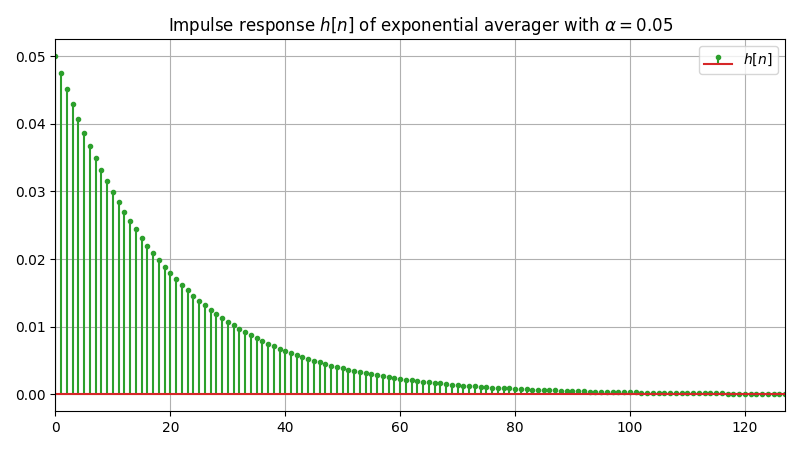

In [39]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt 
def exponential_averaging(x: np.ndarray, alpha=0.1):
    """
    Function to perform exponential averaging on an input signal 'x'. 
    Filtering function: y[n] = alpha*x[n] + (1-alpha)*y[n-1]

    Parameters:
    - x: Array representing input signal
    - alpha: Smoothing factor 0 < alpha < 1

    Returns:
    - y: Array containing filtered output
    """
    L = len(x)  # length of signal
    y = np.zeros(L)
    for n in range(L):
        y[n] = alpha*x[n] + (1-alpha)*y[n-1]
    return y


N = 128
dn = np.zeros(N)
dn[0] = 1
hn = exponential_averaging(dn, alpha=0.05)

plt.close(1); plt.figure(1)
plt.title("Impulse response $h[n]$ of exponential averager with $\\alpha=0.05$")
plt.stem(hn, markerfmt=".", linefmt="C2", label="$h[n]$")
plt.legend(loc="upper right")

* Categorized as an IIR filter because $h[n]$ will never be *precisely* equal to $0$ for any $n\geq0$

# Designing IIR filters

1. Determine desired filter response properties (filter order, lowpass/highpass, cutoff frequency etc...)

In [23]:
f_c = 100 # Cutoff frequency (Hz)
filter_type = "lowpass"
filter_order = 4

2. Design an *analog* filter ([butterworth](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#scipy.signal.butter), [chebyshev](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cheby1.html#scipy.signal.cheby1), [bessel](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bessel.html#scipy.signal.bessel) etc...) with the desired response

Text(0, 0.5, 'Filter gain (dB)')

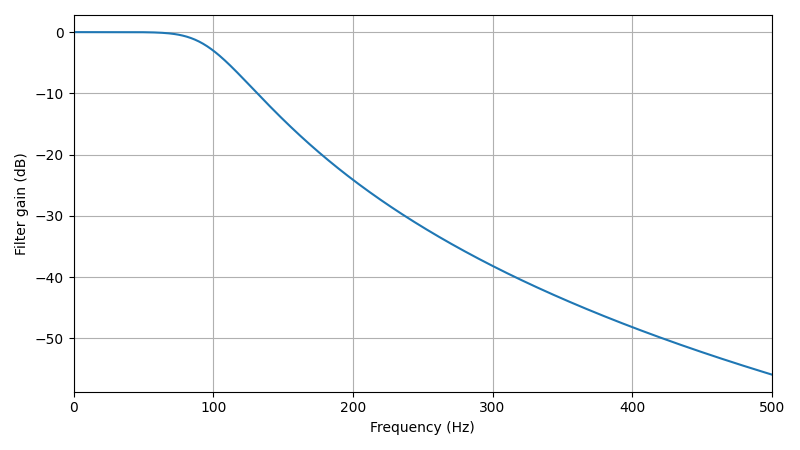

In [24]:
b, a = sig.butter(filter_order, f_c*2*np.pi, filter_type, analog=True)
w, Hw = sig.freqs(b, a, worN=np.pi*2*np.linspace(0, 500, 513))
plt.close(2); plt.figure(2)
plt.plot(w/2/np.pi, 20*np.log10(np.abs(Hw)))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Filter gain (dB)")

3. *Discretize* the analog filter, typically using Tustin's method (aka. Bilinear Transform) with pre-warping.
    * *Tustin's method is preferred for DSP applications because it allows us to retain corner frequencies precisely*

(-100.0, 12.005490853061767)

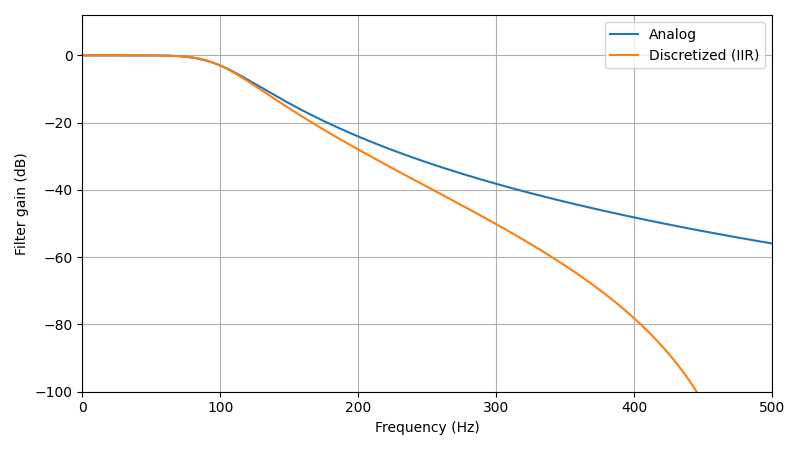

In [26]:
fs = 1_000 # samples / second
fs_warped = (np.pi*f_c)/np.tan(np.pi*f_c/fs)  # Perform pre-warping
b_d, a_d = sig.bilinear(b, a, fs=fs_warped)   # Diskretiser med tustins metode
f_d, Hf_d = sig.freqz(b_d, a_d, fs=fs)

plt.close(3); plt.figure(3)
plt.plot(w/2/np.pi, 20*np.log10(np.abs(Hw)), label="Analog")
plt.plot(f_d, 20*np.log10(np.abs(Hf_d)), label="Discretized (IIR)")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Filter gain (dB)"); plt.ylim(ymin=-100)

## Signal filtering using `scipy`:

* General function for filtering with LTI-systems: [`scipy.signal.lfilter(b, a, x)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html).
* Function Parameters:
    * `b`: Filter coefficients $b_k$
    * `a`: Filter coefficients $a_k$
    * `x`: Array containing input signal $x[n]$ to be filtered.


(0.0, 127.0)

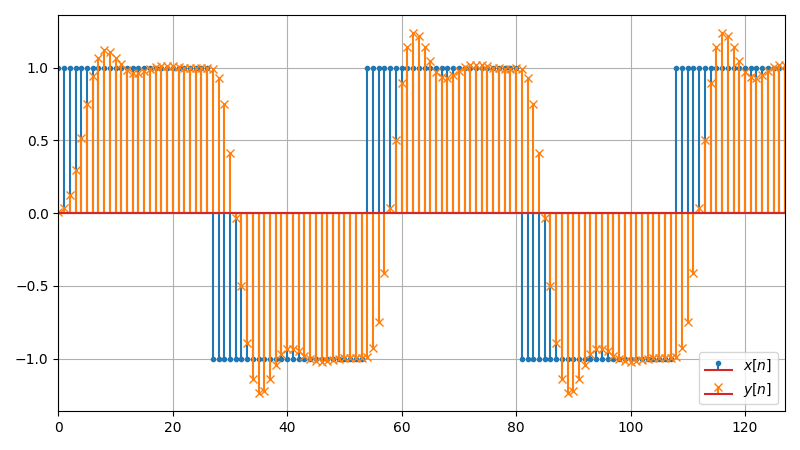

In [27]:
# Example using discretized filter from perevious slide
import scipy.signal as sig

# Generate input square wave signal
N = 128
n = np.arange(N)
xn = sig.square(np.pi/27*n)

# Perform filtering
yn = sig.lfilter(b_d, a_d, xn)

# Display input and output signal
plt.figure()
plt.stem(xn, markerfmt='.', label="$x[n]$")
plt.stem(yn, markerfmt="x", linefmt="C1", label="$y[n]$")
plt.legend(loc="lower right")
plt.xlim([0, N-1])

Mathematically, an IIR filter is identical to a discrete controller or a discretized system model. The only difference is mathematical notation, and the domain of application (the discrete controller is inserted into a closed loop, while the terminology "IIR filter" typically refers to a stand-alone "open-loop" system for filtering e.g. music).

Since the theory behind IIR filters and discrete control theory is the same, IIR filters will not play a major role in this course's curriculum. If you wish a refresher, chapter 6 covers this topic in detail.

# What is a FIR filter?


 


* **FIR** - **F**inite **I**mpulse **R**esponse

* Describes a digital filter which calculates the output $y[n]$ based *only* on a linear combination of the input values $x[n]$ at various samplingtimes.

* Entirely described by the filter coefficients $b_k$

* Can be viewed as a Discrete LTI-system where $a_k$ equals:
$$
a_k = 
\begin{cases}
1,\ \ \  k = 0\\
0,\ \ \  k \neq 0
\end{cases}
$$

* Difference exuation for FIR filters:
### $$ y[n] = \sum_{k=0}^{N} b_k \cdot x[n-k]$$

* $N$ denotes the *filter order*
    * Determines how many samples "back in time" the FIR filter needs to keep samples in the buffer.

* Mathematically much simpler to work with than a IIR filter

# FIR filter system diagram

<img src="Figures/fir_filters/Fig13_FIR_struct.png" style="width: 60%; margin-left: 10%" />




* FIR filters commonly referred to as *tapped delay line* filters

* Number of "taps" ($M=N+1$) are a more common metric for size of filter than the filter order

## Example of a FIR filter: *moving average filter*
* The output $y[n]$ is the ***mean*** of the $M$ most recent input values $x[n-k], k \in \{0, 1, \ldots , M-1\}$.

$$y[n] = \frac{1}{M} \sum_{k=0}^{M-1} x[n-k]$$



(0.0, 127.0)

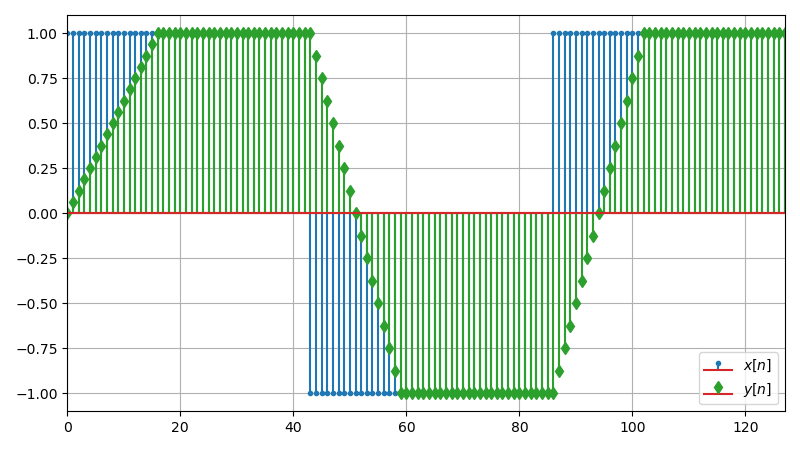

In [3]:
def exponential_averaging(x: np.ndarray, M=16):
    """
    Function to perform moving average filtering of an input signal 'x'.
    Filtering function: y[n] = (x[n] + x[n-1] + ... + x[n-K+1])/K

    Parameters:
    - x: Array representing input signal
    - K: Length of averaging "window"

    Returns:
    - y: Array containing filtered output
    """
    L = len(x)
    y = np.zeros(L)
    for n in range(L):
        y[n] = np.sum(x[max(n-M, 0):n])/M
    return y


N = 128
n = np.arange(N)
xn = sig.square(2*np.pi*1.5*n/N)
yn = exponential_averaging(xn, M=16)

plt.figure()
plt.stem(xn, markerfmt='.', label="$x[n]$")
plt.stem(yn, markerfmt="d", linefmt="C2", label="$y[n]$")
plt.legend(loc="lower right")
plt.xlim([0, N-1])

## Question:

* What are the filter coefficients $b_k$ of a $M=8$-tap moving average filter?

# Designing/analyzing FIR filters



<img src="Figurer/10_Digitale Filtre Intro/Fig10_hn.png" align="right" width="25%" margin-left="10%"/>

<div style="width: 50%"><ul><li> Working with FIR filters involves analyzing/shaping the <i>Impulse Response</i> of the FIR filter.</li></ul></div>


* The impulse response of a FIR filter is easily acquired.
    * This is in contrast to IIR filters where calculating the impulse response is highly cumbersome, and therefore rarely relevant for analyzing IIR filters.

# FIR filters impulse response

\begin{align}
h[n] &= \sum_{k=0}^{M} b_k \cdot \delta[n-k]\\
     &= b_0 \cdot \delta[n] + b_1\cdot \delta[n-1] + \ldots + b_M\cdot \delta[n-M]\\ \\
     &= \begin{cases} b_k \big|_{k=n}, & 0 \leq n \leq M \\ 0, & \text{otherwise} \end{cases}
\end{align}



* The impulse response of a FIR filter is a signal which contains each filter coefficient $b_k$ in turn.

| $$n$$ | $$ n < 0 $$ | $$0$$ | $$1$$ | $$2$$ | $$3$$ | $$\ldots$$ | $$N$$ | $$N+1$$ | $$n > N +1 $$ |
|---|---|---|---|---|---|---|---|---|---|
|$$x[n] = \delta[n]$$ | $$0$$ | $$1$$ |  $$0$$ | $$0$$ | $$0$$ | $$0$$ | $$0$$ | $$0$$ | $$0$$ |
|$$y[n] = h[n]$$ |$$0$$ | $$b_0$$ | $$b_1$$ | $$b_2$$ | $$b_3$$ | $$\ldots$$ | $$b_N$$ | $$0$$ | $$0$$|

## Question
* What is the impulse respone $h[n]$ of an 8-point moving average filter?

# Why the impulse response $h[n]$ of a filter is important


1. Any signal can be decomposed into a sum of scaled and shifted deltapulses.

$$x[n] = \sum_{k=0}^{\infty} x[k] \cdot \delta[n-k]$$



2. The properties of *linearity* and *time-invariance* imply that the ouputput of a LTI-system can be expressed as a sum of scaled and shifted *impulse responses*.
\begin{align}
y[n] &= F(x[n])\\
     &= F\left(\sum_{k=-\infty}^{\infty} x[k]\cdot \delta[n-k]\right)\\
     &= \sum_{k=-\infty}^{\infty} x[k]\cdot F(\delta[n-k])\\
     &= \sum_{k=-\infty}^{\infty} x[k]\cdot h[n-k]
\end{align}

# Convolution

* The output of a LTI-ystem can be calucated by ***convolving*** the input signal $x[n]$ with the system's impulse response $h[n]$.
    * Convolution operator: $*$

\begin{align}
y[n] &= \sum_{k=-\infty}^{\infty} x[k]\cdot h[n-k]\\
&= x[n]*h[n]
\end{align}

* Using convolution to calculate the output of a IIR filter is not practical
    * The impulse response $h[n]$ of an IIR filter is infinitely long, resulting in an infinite number of calculations

* FIR filters are filters which in practice perform convolution
    * The impulse response and the filter coefficients are the same array of numbers

## Demo: Filtrering av signal med konvolusjon

Output()

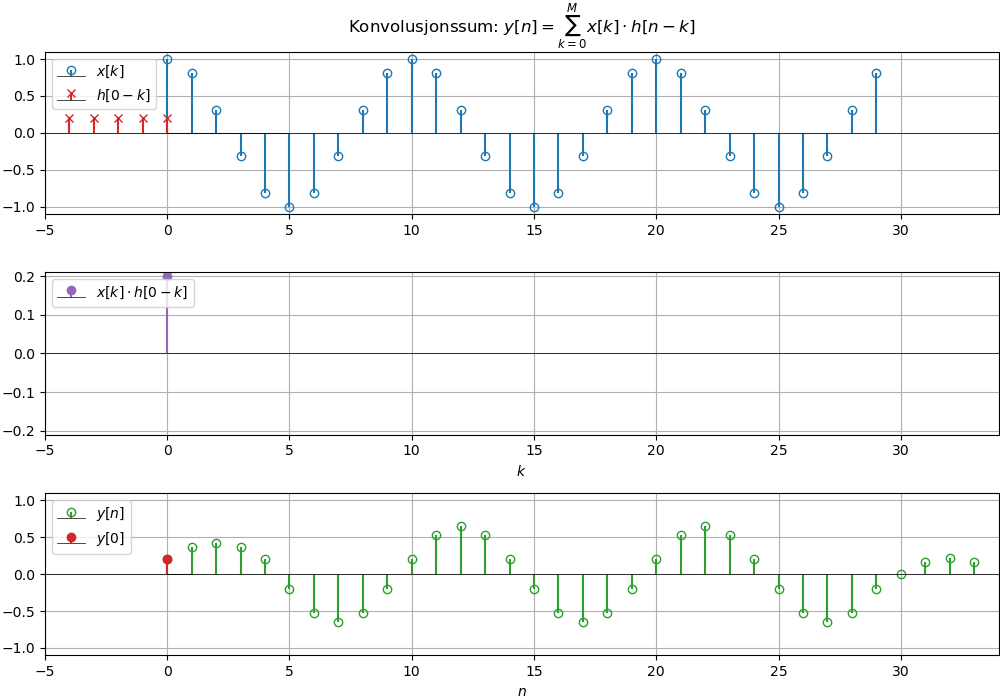

In [13]:
from Kildekode._10_Konvolusjon import convolutionDemo
n = np.arange(30); xn = np.cos(pi/5*n) # Sinussekvens
hn =  np.array(np.ones(5)/5)                      # 
convolutionDemo(xn, hn, fig_num=2,figsize=(10,7));    #

* Convolution step-by-step:
    1. Flip the impulse response $h[n]$ aboug $n=0$ (time-reversal)
    2. Calculate the product sum where the signal $x[n]$ overlaps with the flipped impulse response $h[-n]$
    3. Shift the flipped impulse response one step along the $x$-axis
    4. Repeat step 2 & 3 as long as there are overlapping samples
 
* You are encouraged to used try out the demo with various input signals and impulse responses

## Observations

* Output signal length equals the sum of input signal length and impulse response length minus 1:
$$L_y = L_x + M-1$$

* The digital filter has a "response time", and the waveform of the filtered signal will typically lag behind the input signal.

# Calculating convolution

* When calculating by hand, the simplest approach is to use a multiplication table
<br>
<br>

<div>
<img src="Figurer/10_Digitale Filtre Intro/ConvIllustration1.png" width="43%" align="left"/>
</div>

# Calculating convolution

* When calculating by hand, the simplest approach is to use a multiplication table
* The convolution result is found by adding up the products along each diagonal

<img src="Figurer/10_Digitale Filtre Intro/ConvIllustration2.png" width="65%" align="left" />

## Programming example: *create a function to calculate convolution "from scratch"*

$$ y[n] = \sum_{k=0}^{\infty}x[k]\cdot h[n-k]$$


In [24]:
def convolve(x, h):
    
    M = len(h)  # Number of filter "taps"
    L_x = len(x)  # Length of input signal
    L_y = M + L_x -1   # Length of filtered signal
    y = np.zeros(L_y)  # "Empty" output signal
    
    for n in range(L_y):  # For each sample in the output y[n]
        for k in range(M):  # For each "tap" in the filter
            if 0 <= n - k < M:  # If x[k] overlaps with h[n-k]
                y[n] += x[k]*h[n-k]
    return y

x = np.ones(10)
h = np.ones(5)
convolve(x, h)

array([1., 2., 3., 4., 5., 5., 5., 5., 5., 5., 4., 3., 2., 1.])

# Convolution using python

* The `numpy` module has a function  [`convolve()`](https://numpy.org/doc/2.0/reference/generated/numpy.convolve.html).

<StemContainer object of 3 artists>

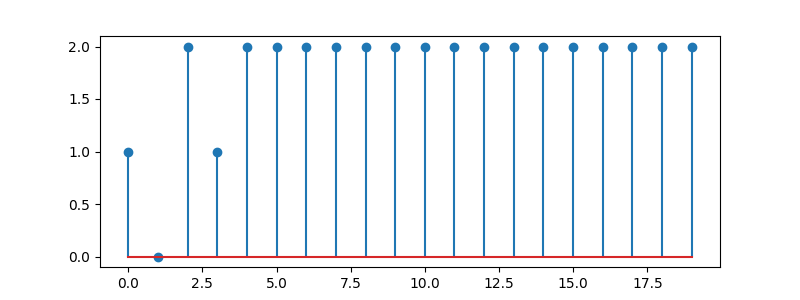

In [4]:
xn = np.ones(20) # x[n] = u[n]-u[n-10]
hn = np.array([1, -1, 2, -1, 1]) # Fra regneeksempel 2
yn = np.convolve(xn, hn)
yn = yn[:20]
plt.close(3);plt.figure(3, figsize=(8,3))
plt.stem(yn)

# Step response and the transitional phase

* The step response $s[n]$ of of a filter $h[n]$ is defined as the outpu signal $y[n]$ when the input $x[n]$ is a [heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) $u[n]$




$$s[n] = h[n]*u[n]$$

* Equivalent to the running sum of the impulse response: $$s[n] = \sum_{k=0}^n h[k]$$


* Eksempel med 5-punkts middelverdifilter:
<img src="Figurer/10_Digitale Filtre Intro/StepResponse.png" width="65%"/>

* The *Transitional phase* can be fomulated as *"number of samples of lag before the filter output adjusts to sudden changes in the input signal"*
    * Example: if the frequency of a input sinusoid is changed suddenly, it will take $N$ samples before the output can be considered as strictly sinusoidal

## Regneeksempel 2:
* Calculate the step response of the filter
$$h[n] = \delta[n]-\delta[n-1]+2\delta[n-2]-\delta[n-3]+\delta[n-4]$$

# Convolution in image processing: *edge detection*

* Simple FIR filters such as a first order difference filter *can* be used to highlight edges in images
    * $h[n] = \delta[n] - \delta[n-1]$
    
#### Below we can see a grayscale image, as well as an intensity profile from one row in the image.

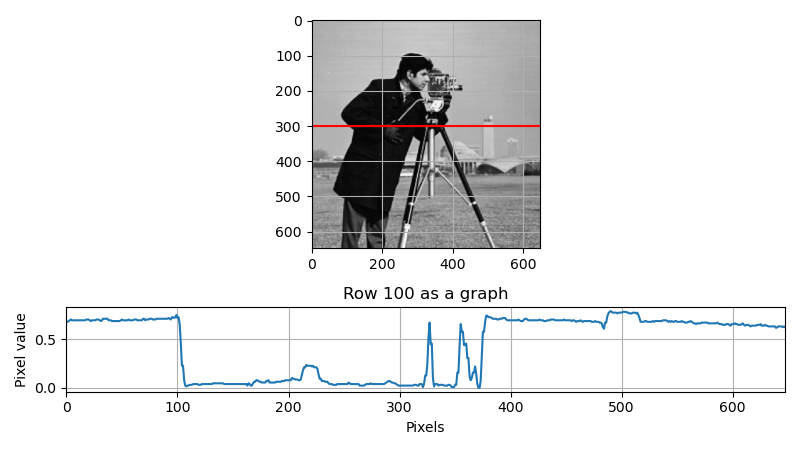

In [22]:
Im = plt.imread("Figures/fir_filters/camera.png")
Im = Im[:,:,0]  # Extract grayscale image as 2D array
plt.figure()
plt.subplot(3,1,(1,2))
plt.imshow(Im, cmap="gray")
rows, cols = Im.shape
plt.plot([0, cols-1], [300, 300], 'r')
plt.subplot(3,1,3)
plt.plot(Im[300,:])
plt.title("Row 100 as a graph")
plt.xlabel('Pixels')
plt.ylabel('Pixel value')
plt.tight_layout()

### We can use the differenc filter to filter each pixel row/column individually

Text(0.5, 1.0, 'Vertical difference filter')

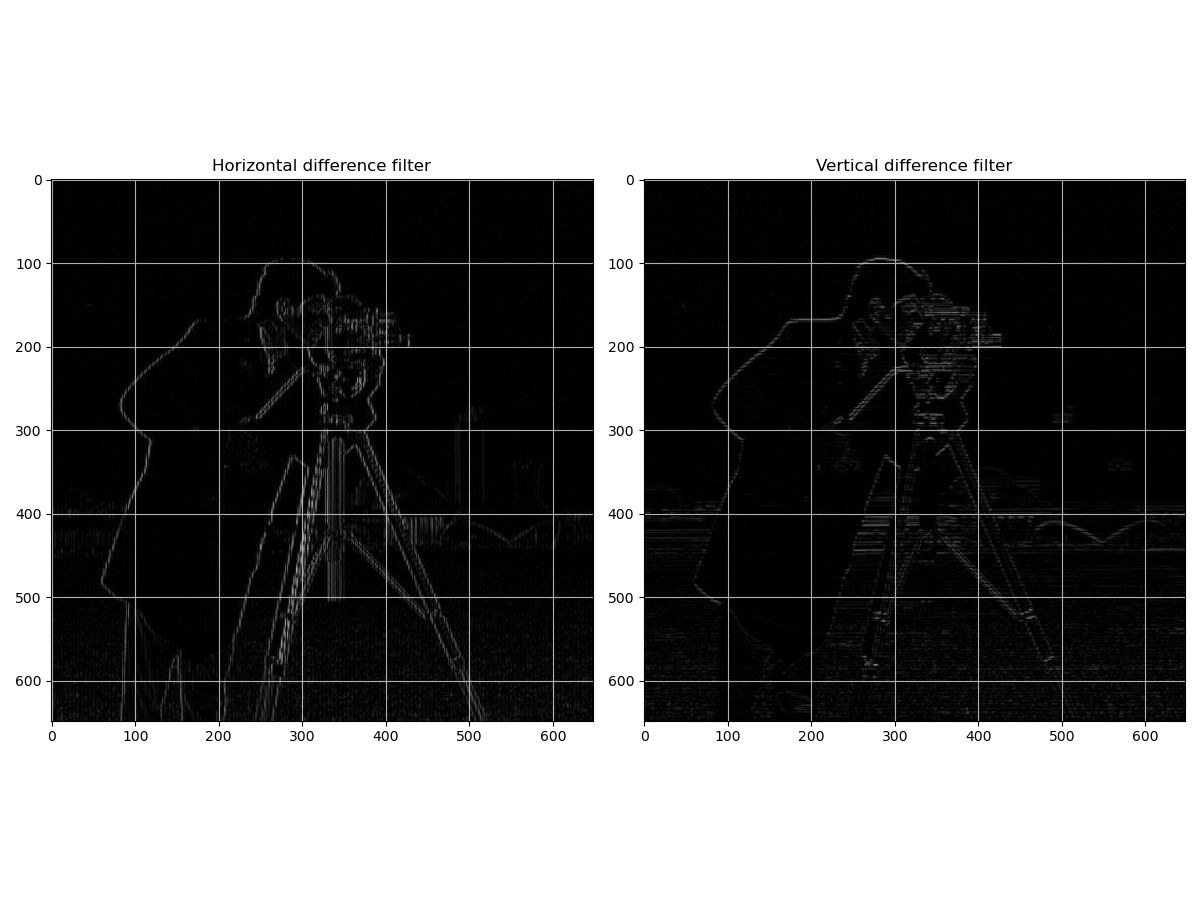

In [23]:
h = np.array([1, -1])
h_hori = h.reshape(1, 2)  # Single row, two columns
h_vert = h.reshape(2, 1)  # Single column, two rows

# Filter image in each direction
Im_filt_h = sig.convolve2d(Im, h_hori, mode="same")
Im_filt_v = sig.convolve2d(Im, h_vert, mode="same")

# Plot the result
plt.figure(figsize=(12,9))
plt.subplot(1,2,1)
plt.imshow(abs(Im_filt_h), cmap="gray")
plt.title("Horizontal difference filter")
plt.subplot(1,2,2)
plt.imshow(abs(Im_filt_v), cmap="gray")
plt.title("Vertical difference filter")

### Combine the two images. 

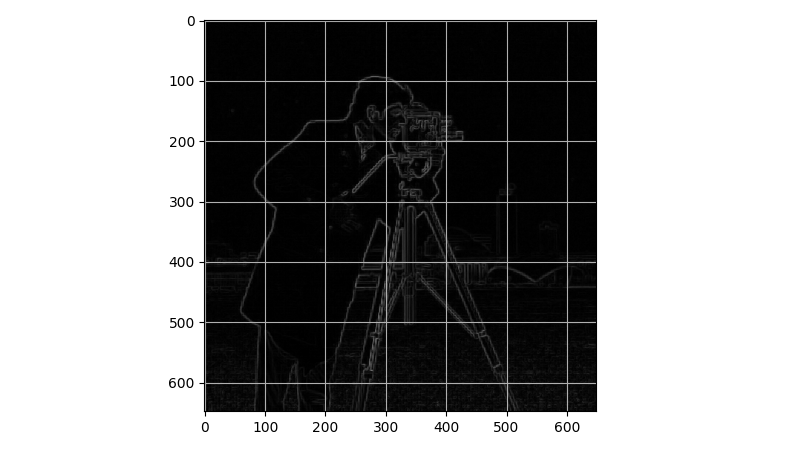

In [81]:
Im_filt = np.sqrt(Im_filt_h**2 + Im_filt_v**2)
plt.figure()
plt.imshow(np.abs(Im_filt), cmap="gray")

### Use thresholding to create a binary image showing the location of edges

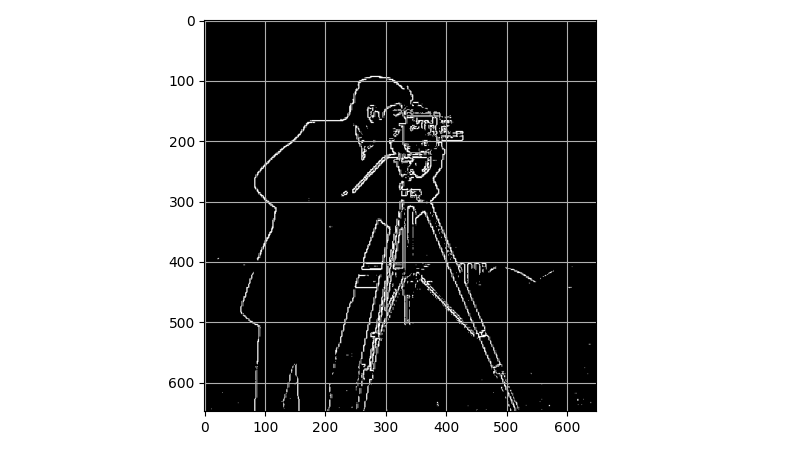

In [85]:
threshold = 0.15
Im_edges = Im_filt > threshold*np.max(Im_filt)
plt.figure()
plt.imshow(np.abs(Im_edges), cmap="gray")

# Convolution properties

1. Commutative
\begin{align}
x[n]*y[n] &= y[n]*x[n] \\
\sum_{k=-\infty}^{\infty} x[k]\cdot y[n-k] &= \sum_{k=-\infty}^{\infty} y[k]\cdot x[n-k]
\end{align}


2. Associative
$$(x[n]*y[n])*v[n] = x[n]*(y[n]*v[n])$$


3. Distributive *(linearity)*
$$(x[n] + y[n])*v[n] = x[n]*v[n] + y[n]*v[n]$$


4. Convolution in the frequency domain
$$ x[n]*y[n] \leftrightarrow X\left(\hat{\omega} \right)\cdot Y\left(\hat{\omega} \right)$$

<img src="Figurer/10_Digitale Filtre Intro/Fig12_LTI_par.png" style="width: 80%" />

<img src="Figurer/10_Digitale Filtre Intro/Fig12_LTI_cas.png" style="width: 80%" />

## Regneeksempel 3:

* Gitt følgende scenario:
    1. Vi vil regne ut den deriverte til et inngangssignal $x[n]$
        * Kan ut føres med et derivasjonsfilter: $h_1[n] = (\delta[n] - \delta[n-1])\cdot \frac{1}{T_s}$
    2. $x[n]$ inkluderer en del målestøy, og vi er i hovedsak interessert i den lavfrekvente delen av signalet $x[n]$.
        * Høyfrekvent støy vil forsterkes veldig av et derivasjonsfilter.
    3. Det foreslås å bruke et *middelverdifilter* med lengde *L=6* for å lavpassfiltrere det deriverte signalet.
        * Vi kombinerer altså et middelverdifilter i kaskade med derivasjonsfilteret.
    
* Finn impulsresponsen til det samlede systemet $h_{tot}[n]$.



# Summary

* Digital filters use a linear combination of available signal samples ($x[n-k] \big/ y[n-k]$) to calculate the next output $y[n]$ for each sample.
* The mathematical properties of a *Linear*, and *Time-invariant* system can be inferred from it's *impulse response* $h[n]$.
* The output $y[n]$ for a LTI-system is calculated by *convolving* the input $x[n]$ and the impulse response $h[n]$:
$$y[n] = \sum_{k=0}^{\infty} x[k] \cdot h[n-k] = x[n]*h[n]$$
* Utgangssignalet $y[n]$ til et LTI-system utregnes ved *konvolusjon* ($y[n] = x[n]*h[n]$).
* FIR filters are *"convolution machines"*
    * A LTI-system which ***only*** uses previous imput samples (x[n-k]) to calculate the output $y[n]$
        * $y[n] = b_0 \cdot x[n] + b_1 \cdot x[n-1] + \ldots + b_N \cdot x[n-N]$
    * The impulse response $h[n]$ is simply the a signal containing each filter coefficient $b_k$ in turn.
* Two LTI-systems in cascade will have a total impulse response $h[n] = h_a[n] * h_b[n]$
* Two LTI-systems in parallell will have a total impulse respones $h[n] = h_a[n] + h_b[n]$